# Solving Toeplitz Linear Systems
This notebook has implementations of Levinsons algorithm, Conjugate Gradient and Preconditioned Conjugate Gradient, to solve Toeplitz systems on the form $A x = b$, where $A$ is a Toeplitz matrix. 

# Import packages

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import linalg
from scipy.linalg import circulant
from scipy.linalg import solve_toeplitz, toeplitz
from scipy.linalg import matmul_toeplitz
from scipy.linalg import sqrtm
import scipy.fft
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Define colors from DTU Design Guide
dtu_blue = (1/255)*np.array([47,62,234])
dtu_bright_green = (1/255)*np.array([31,208,130])
dtu_navy = (1/255)*np.array([3,15,79])
dtu_yellow = (1/255)*np.array([246,208,77])
dtu_orange = (1/255)*np.array([252,118,52])
dtu_pink = (1/255)*np.array([247,187,177])
dtu_grey = (1/255)*np.array([218,218,218])
dtu_red = (1/255)*np.array([232,63,72])
dtu_green = (1/255)*np.array([0,165,53])
dtu_purple = (1/255)*np.array([121,35,142])

# Levinson's algorithm

In [3]:
# Levinson's algorithm
def Levinson(a,b):
    # Normalize diagonal elements
    r0 = a[0]
    a = (1/r0)*a

    # Initialize
    n = np.size(a)
    x = np.zeros(n,dtype=np.complex64)
    y = np.zeros(n,dtype=np.complex64)
    v = np.zeros(n,dtype=np.complex64)
    z = np.zeros(n,dtype=np.complex64)
    r = a
    y[0] = -r[1]
    x[0] = b[0]
    beta = 1
    alpha = -r[1]

    for k in range(1,n):
        beta = (1 - alpha**2)*beta
        mu = (b[k] - np.dot(r[1:k+1],x[0:k][::-1]))/ beta
        v[0:k] = x[0:k] + mu*y[0:k][::-1]
        x[0:k+1] = np.concatenate((v[0:k],[mu]),axis=0)
        if k < n-1:
            alpha = (-r[k+1] - np.dot(r[1:k+1],y[0:k][::-1]))/ beta
            z[0:k] = y[0:k] + alpha*y[0:k][::-1]
            y[0:k+1] = np.concatenate((z[0:k],[alpha]),axis=0)
    x = 1/r0*x
    return x

# Conjugate Gradient + Preconditioned Conjugate Gradient

In [4]:
# Function to make vector c of size n based on vector a
def make_vector_c(n,a):
    m = np.size(a)
    c = np.zeros(n,dtype=np.complex64)
    c[0] = a[0]
    for k in range(1,m):
        c[k] = a[k]
    for k in range(m,n):
        c[k] = a[k-n]
    for k in range(1,n):
        c[-k] = c[k]
    return c
                
def make_vector_c(n,a):
    m = np.size(a)
    if m > (n/2):
        if n % 2 == 0:
            m = int(n/2)
        elif n % 2 == 1:
            m = int((n-1)/2)
    c = np.zeros(n,dtype=np.complex64)
    for k in range(m+1):
        c[k] = a[k]
    for k in range(m+1,n):
        c[k] = a[k-n]
    for k in range(1,n):
        c[-k] = c[k].conj()
    return c
            
# Function to make L and the inverse of L of size nxn using fft 
def make_L(n,a):
    c = make_vector_c(n,a)
    eigen = sp.fft.fft(c)

    eigen_smallest = np.sort(np.real(eigen))[0]

    if abs(eigen_smallest) < pow(10,-12):
        print('Warning: C not invertible')

    Lambda = np.diag(eigen)
    Lambda_half = np.sqrt(Lambda)

    # Compute L, L^-1 using fft
    temp = (1/math.sqrt(n)*sp.fft.fft(Lambda_half))
    L = (1/math.sqrt(n)*sp.fft.fft(temp.T.conj())).conj()

    temp = (1/math.sqrt(n)*sp.fft.fft(np.sqrt(np.diag(1/eigen))))
    L_inv = (1/math.sqrt(n)*sp.fft.fft(temp.T.conj())).conj()

    return L,L_inv

In [5]:
# Conjugate Gradient
def conjugate_gradient(a,b,x,tol,max_iter):    
    # Compute r, p
    r = b - sp.linalg.matmul_toeplitz(a,x)
    p = r

    res = np.linalg.norm(r,ord=2)

    # Inner product of (r,r)
    rsnew = np.sum(r.conj()*r).real

    # Begin iterations
    for i in range(max_iter):
        Ap = sp.linalg.matmul_toeplitz(a,p)
        alpha = rsnew/(np.sum(p.conj()*Ap))
        x = x + alpha*p
        r = r - alpha*Ap    
    
        rsold = rsnew
        rsnew = np.sum(r.conj()*r)
        p = r+rsnew/rsold*p

        # Convergence test
        if np.linalg.norm(r,ord=2)/res < tol:
            break
      
    return x,i

In [6]:
# Split Preconditioner Conjugate Gradient
def pre_conjugate_gradient(a,b,x,tol,max_iter,li,li_adj):    
    # Compute r, r_hat, p
    r = b - sp.linalg.matmul_toeplitz(a,x)
    r_hat = sp.linalg.matmul_toeplitz((li,li),r)

    p = sp.linalg.matmul_toeplitz((li_adj,li_adj),r_hat)

    res = np.linalg.norm(r_hat,ord=2)

    # Begin iterations
    for i in range(max_iter):

        # Compute inner product of (r_hat,r_hat)
        rsnew_hat = np.sum(r_hat.conj()*r_hat)

        Ap = sp.linalg.matmul_toeplitz(a,p)
        alpha = rsnew_hat/(np.sum(p.conj()*Ap))
        x = x + alpha*p

        r_hat = r_hat - alpha*(sp.linalg.matmul_toeplitz((li,li),Ap))

        rsold_hat = rsnew_hat
        rsnew_hat = np.sum(r_hat.conj()*r_hat)
        
        p = sp.linalg.matmul_toeplitz((li_adj,li_adj),r_hat) + rsnew_hat/rsold_hat*p

        # Convergence test
        if np.linalg.norm(r_hat,ord=2)/res < tol:
            break

    return x,i


# Generate test signal 

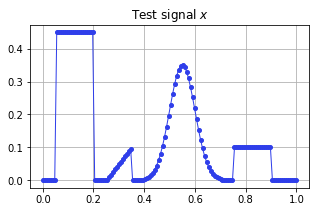

In [7]:
# Generate test signal 
def Generate_Test_Signal(x, peaks):

    Signal = np.zeros(len(x))

    Signal[np.logical_and(0.05 <= x, x <= 0.2)] = peaks[0]

    Signal[np.logical_and(0.25 <= x, x <= 0.35)] = peaks[1]/0.1*x[np.logical_and(0.25<=x, x<=0.35)]-2.5*peaks[1]

    Signal[np.logical_and(0.4 < x, x < 0.75)] = peaks[2]*np.exp(-((x[np.logical_and(0.4<x, x<0.75)]-0.55)**2)*200)

    Signal[np.logical_and(0.75 <=x, x <= 0.9)] = peaks[3]

    return Signal

n = 128
t = np.linspace(0,1,n,endpoint=True)

# Peaks determines the height of the functions in the test problem
peaks = np.array([0.45, 0.1, 0.35, 0.1])

# Setup of the test problem
x = Generate_Test_Signal(t, peaks)

plt.figure(figsize=(5,3))
plt.plot(t,x,'o-',lw=1,markersize=4,color=dtu_blue)
plt.title('Test signal $x$')
plt.grid()
plt.show()

# Example 1: Tridiagonal matrix

In this example we will solve $A_n x = b$, where $A_n$ is a tridiagonal matrix with $a_0$ in the main diagonal and $-1$ in the other diagonals. We investigate the cases where $a_0 = 2$ and $a_0 = 10$.

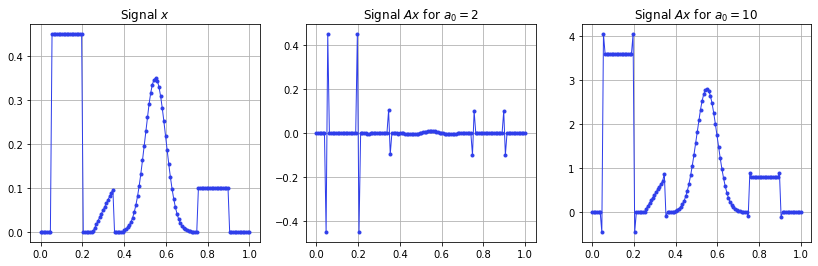

In [15]:
# Plot x and Ax 
n = 128
t = np.linspace(0,1,n,endpoint=True)
x = Generate_Test_Signal(t, peaks)

a = np.zeros(n,dtype=np.complex64)
a[0] = 2
a[1] = -1
Ax = sp.linalg.matmul_toeplitz(a,x)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(t,np.real(x),'o-',color=dtu_blue,lw=1,markersize=3)
plt.title('Signal $x$')
plt.grid()

plt.subplot(1,3,2)
plt.plot(t,np.real(Ax),'o-',color=dtu_blue,lw=1,markersize=3)
plt.title('Signal $Ax$ for $a_0 = 2$')
plt.grid()

a[0] = 10
Ax = sp.linalg.matmul_toeplitz(a,x)

plt.subplot(1,3,3)
plt.plot(t,np.real(Ax),'o-',color=dtu_blue,lw=1,markersize=3)
plt.title('Signal $Ax$ for $a_0 = 10$')
plt.grid()

plt.show() 


In [16]:
# Find running time of solving Ax = b for different n
all_n = []
for i in range(4,14):
    all_n.append(2**i)

all_t_Levinson_i = []
all_t_CG_i = []
all_t_Levinson_w = []
all_t_CG_w = []

tol = pow(10,-7)
max_iter = 500

for n in all_n:

    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    a[1] = -1
  
    b = np.ones(n,dtype=np.complex64)
    t = np.linspace(0,1,n,endpoint=True)
    x0 = Generate_Test_Signal(t, peaks)

    t = time.time()
    x_Levinson = Levinson(a,b)
    elapsed = time.time() - t
    all_t_Levinson_i.append(elapsed)
    
    t = time.time()
    x_CG, i = conjugate_gradient(a,b,x0,tol,max_iter)
    elapsed = time.time() - t
    all_t_CG_i.append(elapsed)

    a = np.zeros(n,dtype=np.complex64)
    a[0] = 10
    a[1] = -1
  
    t = time.time()
    x_Levinson = Levinson(a,b)
    elapsed = time.time() - t
    all_t_Levinson_w.append(elapsed)
    
    t = time.time()
    x_CG,i = conjugate_gradient(a,b,x0,tol,max_iter)
    elapsed = time.time() - t
    all_t_CG_w.append(elapsed)

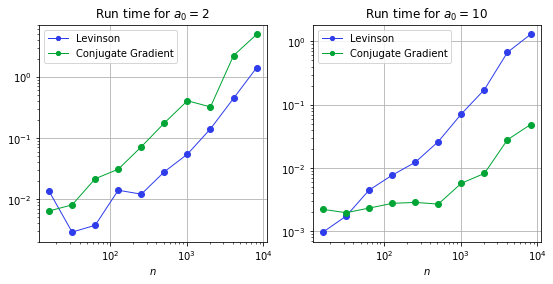

In [18]:
# Plot running time
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(all_n,all_t_Levinson_i,'o-',color=dtu_blue,lw=1)
plt.plot(all_n,all_t_CG_i,'o-',color=dtu_green,lw=1)
plt.legend(['Levinson','Conjugate Gradient'],markerscale=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.title('Run time for $a_0=2$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(all_n,all_t_Levinson_w,'o-',color=dtu_blue,lw=1)
plt.plot(all_n,all_t_CG_w,'o-',color=dtu_green,lw=1)
plt.legend(['Levinson','Conjugate Gradient'],markerscale=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.title('Run time for $a_0=10$')
plt.grid()

plt.show()

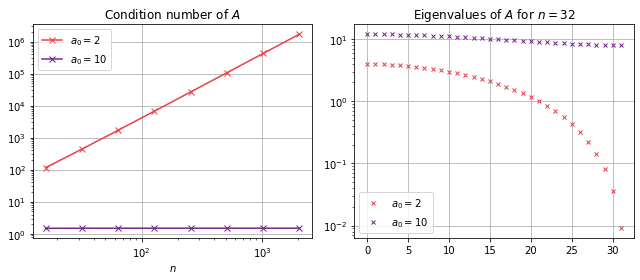

In [25]:
# Plot condition number and spectrum
cond_A_i = []
cond_A_w = []

all_n = []
for i in range(4,12):
    all_n.append(2**i)

for n in all_n:
    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    a[1] = -1
    A = linalg.toeplitz(a.conj(),a)
    cond_A_i.append(np.linalg.cond(A,2))

    a = np.zeros(n,dtype=np.complex64)
    a[0] = 10
    a[1] = -1
    A = linalg.toeplitz(a.conj(),a)
    cond_A_w.append(np.linalg.cond(A,2))

plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(all_n,cond_A_i,'x-',color=dtu_red)
plt.plot(all_n,cond_A_w,'x-',color=dtu_purple)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.legend(['$a_0 = 2$','$a_0 = 10$'])
plt.title('Condition number of $A$')
plt.grid()

n = 32
a = np.zeros(n,dtype=np.complex64)
a[0] = 10
a[1] = -1 
A = linalg.toeplitz(a,a.conj())
eig_A = np.linalg.eigvalsh(A)

a[0] = 2
A = linalg.toeplitz(a,a.conj())
eig_A_i = np.linalg.eigvalsh(A)

plt.subplot(1,2,2)
plt.plot(eig_A_i[::-1],'x',markersize=4,color=dtu_red)
plt.plot(eig_A[::-1],'x',markersize=4,color=dtu_purple)
plt.legend(['$a_0 = 2$','$a_0 = 10$'])
plt.title('Eigenvalues of $A$ for $n=32$')
plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()

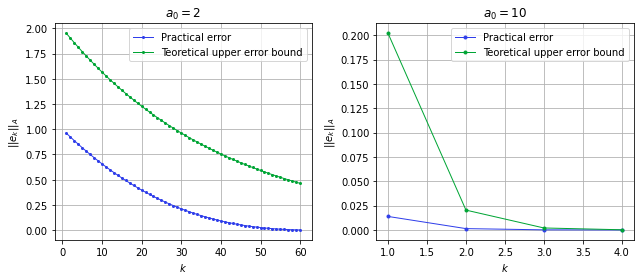

In [23]:
# Plot theoretic and practical error bound
norm_theoretic = []
norm_practical = []

tol = pow(10,-7)

n = 128
a = np.zeros(n,dtype=np.complex64)

b = np.ones(n,dtype=np.complex64)
t = np.linspace(0,1,n,endpoint=True)
x0 = np.zeros(n)

plt.figure(figsize=(9,4))

a[0] = 2
a[1] = -1 

A = sp.linalg.toeplitz(a)
K = np.linalg.cond(A,2)

A_half = sqrtm(A)
a_half = A_half[0]

all_k = np.arange(1,61,dtype=int)

for k in all_k:

    x_CG,i = conjugate_gradient(a,b,x0,tol,k)
    x = sp.linalg.solve_toeplitz(a,b)

    temp = sp.linalg.matmul_toeplitz(a_half,x-x_CG)
    temp2 = sp.linalg.matmul_toeplitz(a_half,x-x0)
    prac = np.linalg.norm(temp,2)/np.linalg.norm(temp2,2)
    norm_practical.append(prac)

    teo = 2*( (np.sqrt(K) - 1)/(np.sqrt(K) + 1) )**k
    norm_theoretic.append(teo)

plt.subplot(1,2,1)
plt.plot(all_k,norm_practical,'o-',color=dtu_blue,markersize=2,lw=1)
plt.plot(all_k,norm_theoretic,'o-',color=dtu_green,markersize=2,lw=1)
plt.xlabel('$k$')
plt.ylabel('$||e_k||_A$')
plt.legend(['Practical error', 'Teoretical upper error bound'])
plt.title('$a_0 = 2$')
plt.grid()

norm_theoretic = []
norm_practical = []

a[0] = 10
a[1] = -1 

A = sp.linalg.toeplitz(a)
K = np.linalg.cond(A,2)

A_half = sqrtm(A)
a_half = A_half[0]

all_k = np.arange(1,5,dtype=int)

for k in all_k:

    x_CG,i = conjugate_gradient(a,b,x0,tol,k)
    x = sp.linalg.solve_toeplitz(a,b)

    temp = sp.linalg.matmul_toeplitz(a_half,x-x_CG)
    temp2 = sp.linalg.matmul_toeplitz(a_half,x-x0)
    prac = np.linalg.norm(temp,2)/np.linalg.norm(temp2,2)
    norm_practical.append(prac)

    teo = 2*( (np.sqrt(K) - 1)/(np.sqrt(K) + 1) )**k
    norm_theoretic.append(teo)

plt.subplot(1,2,2)
plt.plot(all_k,norm_practical,'o-',color=dtu_blue,markersize=3,lw=1)
plt.plot(all_k,norm_theoretic,'o-',color=dtu_green,markersize=3,lw=1)
plt.xlabel('$k$')
plt.ylabel('$||e_k||_A$')
plt.legend(['Practical error', 'Teoretical upper error bound'])
plt.title('$a_0 = 10$')
plt.grid()

plt.tight_layout()
plt.show()

# Example 2: Well conditioned problem

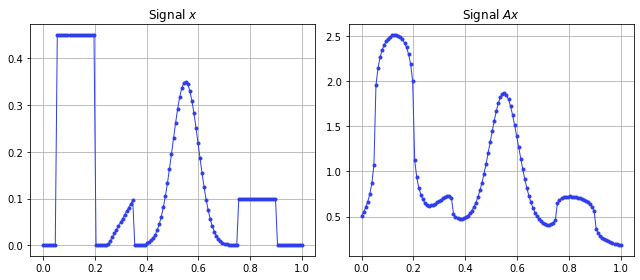

In [28]:
n = 128
t = np.linspace(0,1,n,endpoint=True)
peaks = np.array([0.45, 0.1, 0.35, 0.1])

x = Generate_Test_Signal(t, peaks)

a = np.zeros(n,dtype=np.complex64)
a[0] = 2
for k in range(1,n):
    a[k] = 1/((1+k)**1.1) 

Ax = sp.linalg.matmul_toeplitz(a,x)

plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(t,np.real(x),'o-',color=dtu_blue,lw=1,markersize=3)
plt.grid()
plt.title('Signal $x$')

plt.subplot(1,2,2)
plt.plot(t,np.real(Ax),'o-',color=dtu_blue,lw=1,markersize=3)
plt.grid()
plt.title('Signal $Ax$')

plt.tight_layout()
plt.show()

In [29]:
all_n = []
for i in range(4,14):
    all_n.append(2**i)

all_t_Levinson_w = []
all_t_CG_w = []
all_t_pre_CG_w = []

iter_CG_w = []
iter_pre_CG_w = []

norm_Levinson = []
norm_CG = []

tol = pow(10,-7)
max_iter = 500

for n in all_n:
    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    for k in range(1,n):
       a[k] = 1/((1+k)**1.1) 

    b = np.ones(n,dtype=np.complex64)
    x0 = np.zeros(n,dtype=np.complex64)

    t = time.time()
    x_Levinson = Levinson(a,b)
    elapsed = time.time() - t
    all_t_Levinson_w.append(elapsed)
    
    t = time.time()
    x_CG,i = conjugate_gradient(a,b,x0,tol,max_iter)
    elapsed = time.time() - t
    all_t_CG_w.append(elapsed)
    iter_CG_w.append(i)

    L,Li = make_L(n,a)
    Li_adj = Li.conj().T
    li = Li[0]
    li_adj = Li_adj[0]

    t = time.time()
    x_pre_CG,i = pre_conjugate_gradient(a,b,x0,tol,max_iter,li,li_adj)
    elapsed = time.time() - t
    all_t_pre_CG_w.append(elapsed)
    iter_pre_CG_w.append(i)

In [30]:
# Iterations
print(all_n)
print(iter_CG_w)
print(iter_pre_CG_w)

[16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
[6, 7, 9, 11, 12, 13, 14, 14, 15, 15]
[3, 3, 3, 4, 4, 4, 4, 4, 4, 4]


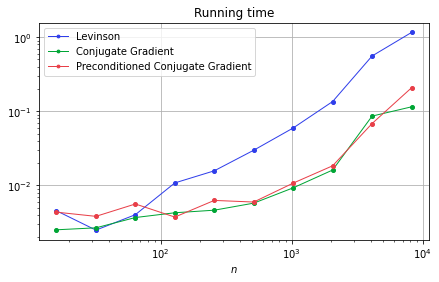

In [32]:
plt.figure(figsize=(7,4))

plt.plot(all_n,all_t_Levinson_w,'o-',color=dtu_blue,markersize=4,lw=1)
plt.plot(all_n,all_t_CG_w,'o-',color=dtu_green,markersize=4,lw=1)
plt.plot(all_n,all_t_pre_CG_w,'o-',color=dtu_red,markersize=4,lw=1)
plt.legend(['Levinson','Conjugate Gradient','Preconditioned Conjugate Gradient'],markerscale=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.title('Running time')
plt.grid()

plt.show()

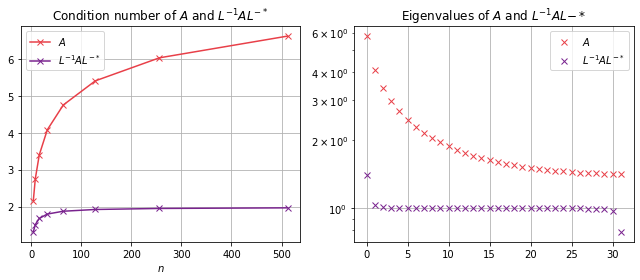

In [50]:
# Plot condition number and eigenvalues

# Compute condition number of A for different n 
cond_A_w = []
cond_pre_A = []

all_n = []
# Set n
for i in range(2,10):
    all_n.append(2**i)

for n in all_n:
    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    for k in range(1,n):
       a[k] = (1)/((1+k)**1.1) 
  
    A = linalg.toeplitz(a.conj(),a)
    cond_A_w.append(np.linalg.cond(A,2))

    L, Li = make_L(n,a)
    Li_adj = np.transpose(Li).conj()
    temp = np.dot(Li,A)
    pre = np.dot(temp,Li_adj)
    cond_pre_A.append(np.linalg.cond(pre,2))

# Compute eigenvalues 
n = 32
a = np.zeros(n,dtype=np.complex64)

a[0] = 2
for k in range(1,n):
    a[k] = (1)/((1+k)**1.1) 
A = linalg.toeplitz(a.conj(),a)

L,Li = make_L(n,a)
Li_adj = Li.conj().T

temp = np.dot(Li,A)
pre = np.dot(temp,Li_adj)
eig_A = np.linalg.eigvalsh(A)
eig_pre = np.linalg.eigvalsh(pre)
 
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(all_n,cond_A_w,'x-',color=dtu_red)
plt.plot(all_n,cond_pre_A,'x-',color=dtu_purple)
plt.xlabel('$n$')
plt.legend(['$A$','$L^{-1}AL^{-*}$'])
plt.title('Condition number of $A$ and $L^{-1}AL^{-*}$')
plt.grid()

plt.subplot(1,2,2)
plt.plot(eig_A[::-1],'x',color=dtu_red)
plt.plot(eig_pre[::-1],'x',color=dtu_purple)
plt.yscale('log')
plt.legend(['$A$','$L^{-1}AL^{-*}$'])
plt.title('Eigenvalues of $A$ and $L^{-1}AL{-*}$')
plt.grid()

plt.tight_layout()
plt.show()


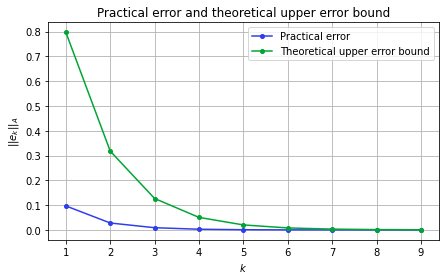

In [40]:
# Plot theoretic and practical error bound
norm_theoretic = []
norm_practical = []

tol = pow(10,-7)

n = 128
a = np.zeros(n,dtype=np.complex64)
a[0] = 2
for k in range(1,n):
    a[k] = 1/((1+k)**1.1) 

x0 = np.zeros(n,dtype=np.complex64)
b = np.ones(n,dtype=np.complex64)

A = sp.linalg.toeplitz(a)
K = np.linalg.cond(A,2)

A_half = sqrtm(A)
a_half = A_half[0]

all_k = np.arange(1,10,dtype=int)

for k in all_k:

    x_CG,i = conjugate_gradient(a,b,x0,tol,k)
    x = sp.linalg.solve_toeplitz(a,b)

    temp = sp.linalg.matmul_toeplitz(a_half,x-x_CG)
    temp2 = sp.linalg.matmul_toeplitz(a_half,x-x0)
    prac = np.linalg.norm(temp,2)/np.linalg.norm(temp2,2)
    norm_practical.append(prac)

    teo = 2*( (np.sqrt(K) - 1)/(np.sqrt(K) + 1) )**k
    norm_theoretic.append(teo)

plt.figure(figsize=(7,4))
plt.plot(all_k,norm_practical,'o-',color=dtu_blue,markersize=4)
plt.plot(all_k,norm_theoretic,'o-',color=dtu_green,markersize=4)
plt.xlabel('$k$')
plt.ylabel('$||e_k||_A$')
plt.title('Practical error and theoretical upper error bound')
plt.legend(['Practical error', 'Theoretical upper error bound'])
plt.grid()
plt.show()


# Example 3: Ill conditioned problem

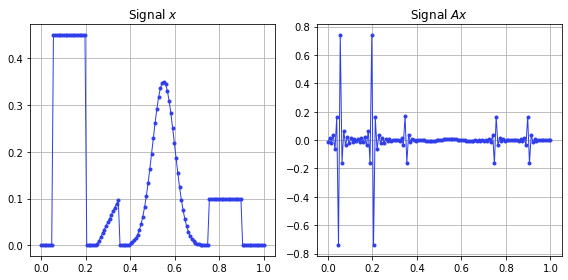

In [44]:
n = 128
t = np.linspace(0,1,n,endpoint=True)
x = Generate_Test_Signal(t, peaks)

a = np.zeros(n,dtype=np.complex64)
a[0] = (math.pi*math.pi)/3
for k in range(1,n):
    a[k] = (2*(-1)**k)/(k**2)

Ax = sp.linalg.matmul_toeplitz(a,x)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(t,np.real(x),'o-',color=dtu_blue,lw=1,markersize=3)
plt.grid()
plt.title('Signal $x$')

plt.subplot(1,2,2)
plt.plot(t,np.real(Ax),'o-',color=dtu_blue,lw=1,markersize=3)
plt.grid()
plt.title('Signal $Ax$')

plt.tight_layout()
plt.show()

In [45]:
# Function to make the DFT matrix of size nxn
def make_DFT(n):
    F = (1/math.sqrt(n))*sp.linalg.dft(n)
    return F

# Function to make L of size nxn 
def make_L(n,a):
    F = make_DFT(n)
    F = F.conj()
    c = make_vector_c(n,a)
    eigen = math.sqrt(n)*(np.dot(F,c.T))
    Lambda = np.diag(eigen)
    Lambda_half = np.sqrt(Lambda)
    Fh = np.transpose(F).conj()
    L = F@Lambda_half@Fh
    L_inv = np.linalg.pinv(L)
    return L, L_inv

In [46]:
all_n = []
# Set n
for i in range(4,12):
    all_n.append(2**i)


all_t_Levinson = []
all_t_CG = []
all_t_pre_CG = []

iter_CG = []
iter_pre_CG = []

tol = pow(10,-7)
max_iter = 500

for n in all_n:

    a = np.zeros(n,dtype=np.complex64)
    a[0] = (math.pi*math.pi)/3
    for k in range(1,n):
        a[k] = (2*(-1)**k)/(k**2)

    b = np.ones(n,dtype=np.complex64)
    x0 = np.zeros(n,dtype=np.complex64)

    t = time.time()
    x_Levinson = Levinson(a,b)
    elapsed = time.time() - t
    all_t_Levinson.append(elapsed)
    
    t = time.time()
    x_CG,i = conjugate_gradient(a,b,x0,tol,max_iter)
    elapsed = time.time() - t
    all_t_CG.append(elapsed)
    iter_CG.append(i)

    L,Li = make_L(n,a)
    Li_adj = np.transpose(Li).conj()

    t = time.time()
    x_pre_CG,i = pre_conjugate_gradient(a,b,x0,tol,max_iter,Li[0],Li_adj[0])
    elapsed = time.time() - t
    all_t_pre_CG.append(elapsed)
    iter_pre_CG.append(i)

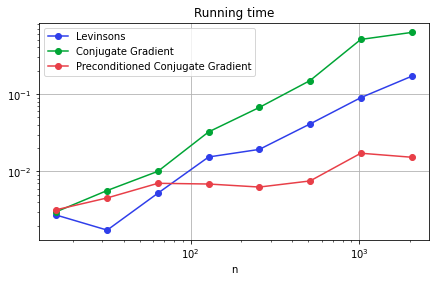

In [47]:
plt.figure(figsize=(7,4))
plt.plot(all_n,all_t_Levinson,'o-',color=dtu_blue)
plt.plot(all_n,all_t_CG,'o-',color=dtu_green)
plt.plot(all_n,all_t_pre_CG,'o-',color=dtu_red)
plt.legend(['Levinsons','Conjugate Gradient','Preconditioned Conjugate Gradient'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('n')
plt.title('Running time')
plt.grid()
plt.show()

In [48]:
# Number of iterations for CG and PCG to converge
print(all_n)
print(iter_CG)
print(iter_pre_CG)

[16, 32, 64, 128, 256, 512, 1024, 2048]
[7, 15, 37, 82, 178, 373, 499, 499]
[4, 5, 4, 4, 4, 4, 4, 4]


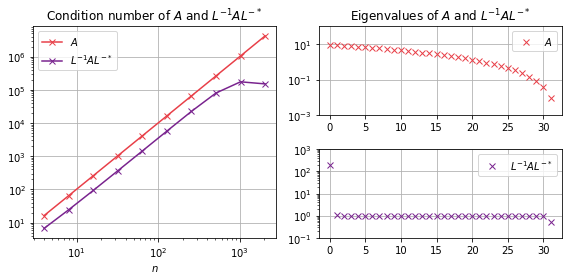

In [52]:
# Plot condition number of A and eigenvalues
cond_A = []
cond_pre_A = []

all_n = []
for i in range(2,12):
    all_n.append(2**i)

for n in all_n:
    a = np.zeros(n,dtype=np.complex64)
    a[0] = (math.pi*math.pi)/3
    for k in range(1,n):
        a[k] = (2*(-1)**k)/(k**2)

    A = linalg.toeplitz(a.conj(),a)
    cond_A.append(np.linalg.cond(A,2))

    L,Li = make_L(n,a)
    Li_adj = np.transpose(Li).conj()
    pre = Li@A@Li_adj

    cond_pre_A.append(np.linalg.cond(pre,2))

# Compute eigenvalues
n = 32
a = np.zeros(n,dtype=np.complex64)
a[0] = (math.pi*math.pi)/3
for k in range(1,n):
    a[k] = (2*(-1)**k)/(k**2)

A = linalg.toeplitz(a,a.conj())

L,Li = make_L(n,a)
Li = np.linalg.pinv(L)
Li_adj = np.transpose(Li).conj()

temp = np.dot(Li,A)
pre = np.dot(temp,Li_adj)
eig_A = np.linalg.eigvalsh(A)
eig_pre = np.linalg.eigvalsh(pre)


# Create 2x2 sub plots
gs = gridspec.GridSpec(2,2)

plt.figure(figsize=(8,4))

ax = plt.subplot(gs[:,0])
plt.plot(all_n,cond_A,'x-',color=dtu_red)
plt.plot(all_n,cond_pre_A,'x-',color=dtu_purple)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.legend(['$A$','$L^{-1}AL^{-*}$'])
plt.title('Condition number of $A$ and $L^{-1}AL^{-*}$')
plt.grid()

ax = plt.subplot(gs[0,1]) 
plt.plot(eig_A[::-1],'x',color=dtu_red)
plt.legend(['$A$'])
plt.yscale('log')
plt.grid()
plt.ylim(pow(10,-3),pow(10,2))
plt.title('Eigenvalues of $A$ and $L^{-1}AL^{-*}$')

ax = plt.subplot(gs[1,1])
plt.plot(eig_pre[::-1],'x',color=dtu_purple)
plt.legend(['$L^{-1}AL^{-*}$'])
plt.ylim(pow(10,-1),pow(10,3))
plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()

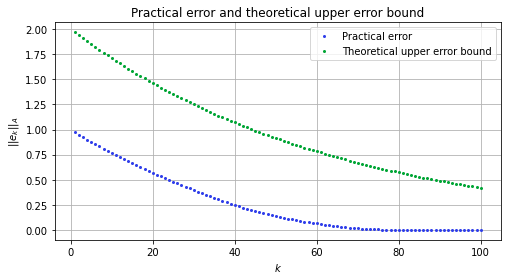

In [53]:
# Plot theoretic and practical error bound
norm_theoretic = []
norm_practical = []

tol = pow(10,-7)

n = 128
a = np.zeros(n,dtype=np.complex64)
a[0] = (math.pi*math.pi)/3
for k in range(1,n):
    a[k] = 2*(-1)**k/(k**2)

x0 = np.zeros(n,dtype=np.complex64)
b = np.ones(n,dtype=np.complex64)

A = sp.linalg.toeplitz(a)
K = np.linalg.cond(A,2)

A_half = sqrtm(A)
a_half = A_half[0]

all_k = np.arange(1,101,dtype=int)

for k in all_k:

    x_CG,i = conjugate_gradient(a,b,x0,tol,k)
    x = sp.linalg.solve_toeplitz(a,b)

    temp = sp.linalg.matmul_toeplitz(a_half,x-x_CG)
    temp2 = sp.linalg.matmul_toeplitz(a_half,x-x0)
    prac = np.linalg.norm(temp,2)/np.linalg.norm(temp2,2)
    norm_practical.append(prac)

    teo = 2*( (np.sqrt(K) - 1)/(np.sqrt(K) + 1) )**k
    norm_theoretic.append(teo)

plt.figure(figsize=(8,4))
plt.plot(all_k,norm_practical,'o',color=dtu_blue,markersize=2)
plt.plot(all_k,norm_theoretic,'o',color=dtu_green,markersize=2)
plt.xlabel('$k$')
plt.ylabel('$||e_k||_A$')
plt.title('Practical error and theoretical upper error bound')
plt.legend(['Practical error', 'Theoretical upper error bound'])
plt.grid()
plt.show()


# Example 4: Gaussian
In this example we consider the Gaussian function
$$f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-x^2/(2 \sigma^2)}.$$
We construgt a Gaussian Toeplitz matrix $A$ with coefficients 
$$a_k = \frac{1}{\sigma \sqrt{2 \pi}} e^{-k^2/(2 \sigma^2)}.$$ 

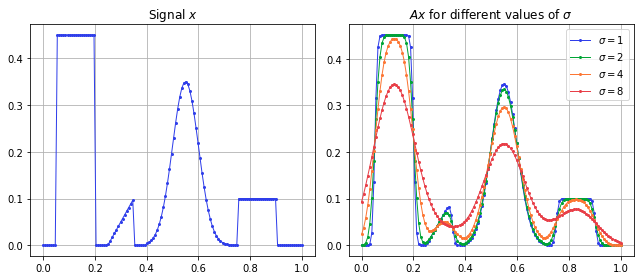

In [55]:
n = 128
t = np.linspace(0,1,n,endpoint=True)
x = Generate_Test_Signal(t, peaks)

sigma_all = [1,2,4,8]

plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(t,np.real(x),'o-',lw=1,markersize=2,color=dtu_blue)
plt.title('Signal $x$')
plt.grid()

plt.subplot(1,2,2)

col = [dtu_blue,dtu_green,dtu_orange,dtu_red]

i = 0

for sigma in sigma_all:
    
    a = np.zeros(n,dtype=np.complex64)
    for k in range(n):
        a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

    Ax = sp.linalg.matmul_toeplitz(a,x)
    plt.plot(t,np.real(Ax),'o-',lw=1,markersize=2,color=col[i])
    i += 1

plt.legend(['$\sigma=1$','$\sigma=2$','$\sigma=4$','$\sigma=8$'])
plt.title('$Ax$ for different values of $\sigma$')
plt.grid()

plt.tight_layout()
plt.show()

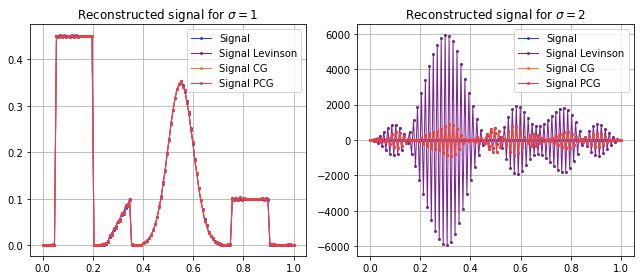

In [56]:
# Noise plot
tol = pow(10,-7)
max_iter = 500
n = 128
x0 = np.zeros(n,dtype=complex)

sigma_all = [1]

t = np.linspace(0,1,n,endpoint=True)
peaks = [0.45, 0.1, 0.35, 0.1]
x = Generate_Test_Signal(t, peaks)

a = np.zeros(n,dtype=np.complex64)
x0 = np.zeros(n,dtype=np.complex64)

noise = np.random.normal(0,0.0001,size=n)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(t,x,'o-',lw=1,markersize=2,color=dtu_blue)


for sigma in sigma_all:

    for k in range(n):
        a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

    Ax = sp.linalg.matmul_toeplitz(a,x)

    L,Li = make_L(n,a)
    Li_adj = np.transpose(Li).conj()
    li = Li[0]
    li_adj = Li_adj[0]

    x_solve = sp.linalg.solve_toeplitz(a,Ax+noise)
    x_solve_Lev = Levinson(a,Ax+noise)
    x_solve_CG, i = conjugate_gradient(a,Ax+noise,x0,tol,max_iter)
    x_solve_PCG, i = pre_conjugate_gradient(a,Ax+noise,x0,tol,max_iter,li,li_adj)
    plt.plot(t,abs(x_solve_Lev),'o-',lw=1,markersize=2,color=dtu_purple)
    plt.plot(t,abs(x_solve_CG),'o-',lw=1,markersize=2,color=dtu_orange)
    plt.plot(t,abs(x_solve_PCG),'o-',lw=1,markersize=2,color=dtu_red)
    

plt.legend(['Signal','Signal Levinson','Signal CG','Signal PCG'])
plt.title('Reconstructed signal for $\sigma=1$')
plt.grid()

sigma = 2
for k in range(n):
    a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

Ax = sp.linalg.matmul_toeplitz(a,x)

L,Li = make_L(n,a)
Li_adj = np.transpose(Li).conj()
li = Li[0]
li_adj = Li_adj[0]

x_solve_Lev = Levinson(a,Ax+noise)
x_solve_CG,i = conjugate_gradient(a,Ax+noise,x0,tol,max_iter)
x_solve_PCG, i = pre_conjugate_gradient(a,Ax+noise,x0,tol,max_iter,li,li_adj)

plt.subplot(1,2,2)
plt.plot(t,x,'o-',lw=1,markersize=2,color=dtu_blue)
plt.plot(t,np.real(x_solve_Lev),'o-',lw=1,markersize=2,color=dtu_purple)
plt.plot(t,np.real(x_solve_CG),'o-',lw=1,markersize=2,color=dtu_orange)
plt.plot(t,np.real(x_solve_CG),'o-',lw=1,markersize=2,color=dtu_red)
plt.legend(['Signal','Signal Levinson','Signal CG','Signal PCG'])
plt.title('Reconstructed signal for $\sigma=2$')
plt.grid()

plt.tight_layout()
plt.show()

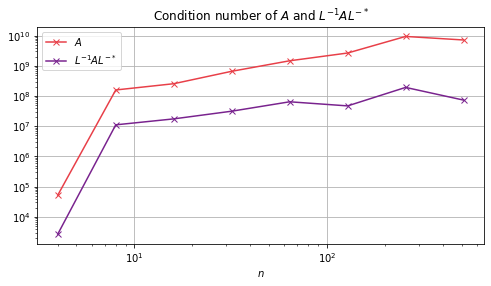

In [57]:
# Plot condition number
cond_A = []
cond_pre_A = []

all_n = []
for i in range(2,10):
    all_n.append(2**i)

sigma = 4

for n in all_n:
    a = np.zeros(n,dtype=np.complex64)
    for k in range(n):
        a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

    A = linalg.toeplitz(a.conj(),a)
    cond_A.append(np.linalg.cond(A,2))

    L,Li = make_L(n,a)
    Li_adj = np.transpose(Li).conj()
    pre = Li@A@Li_adj

    cond_pre_A.append(np.linalg.cond(pre,2))

plt.figure(figsize=(8,4))
plt.plot(all_n,cond_A,'x-',color=dtu_red)
plt.plot(all_n,cond_pre_A,'x-',color=dtu_purple)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$')
plt.legend(['$A$','$L^{-1}AL^{-*}$'])
plt.title('Condition number of $A$ and $L^{-1}AL^{-*}$')
plt.grid()
plt.show()

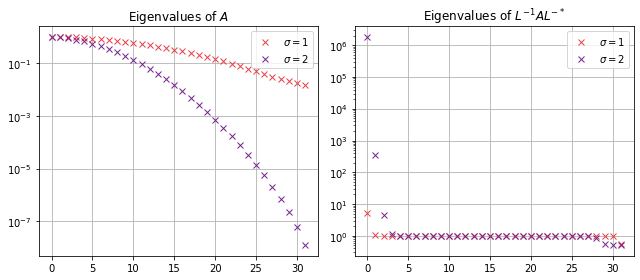

In [58]:
# Plot spectrum 
n = 32

sigma = 1

a = np.zeros(n,dtype=np.complex64)
for k in range(n):
    a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

A = linalg.toeplitz(a)
eig_sigma1 = np.linalg.eigvalsh(A)

L,Li = make_L(n,a)
Li = np.linalg.pinv(L)
Li_adj = np.transpose(Li).conj()
pre = Li@A@Li_adj
eig_sigma1_pre = np.linalg.eigvalsh(pre)

sigma = 2

a = np.zeros(n,dtype=np.complex64)
for k in range(n):
    a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

A = linalg.toeplitz(a)
eig_sigma2 = np.linalg.eigvalsh(A)

L,Li = make_L(n,a)
Li = np.linalg.pinv(L)
Li_adj = np.transpose(Li).conj()
pre = Li@A@Li_adj
eig_sigma2_pre = np.linalg.eigvalsh(pre)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(eig_sigma1[::-1],'x',color=dtu_red)
plt.plot(eig_sigma2[::-1],'x',color=dtu_purple)
plt.yscale('log')
plt.title('Eigenvalues of $A$')
plt.legend(['$\sigma=1$','$\sigma=2$'])
plt.grid()

plt.subplot(1,2,2)
plt.plot(eig_sigma1_pre[::-1],'x',color=dtu_red)
plt.plot(eig_sigma2_pre[::-1],'x',color=dtu_purple)
plt.title('Eigenvalues of $L^{-1}AL^{-*}$')
plt.legend(['$\sigma=1$','$\sigma=2$'])
plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()

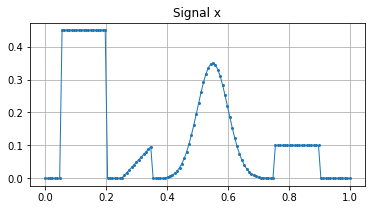

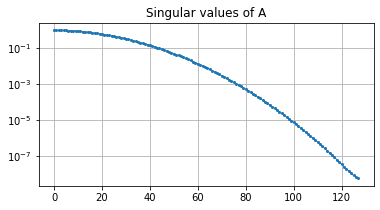

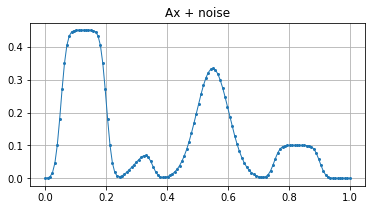

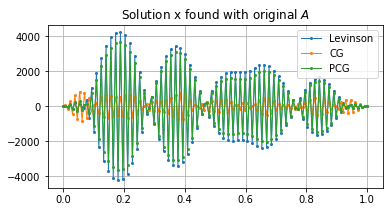

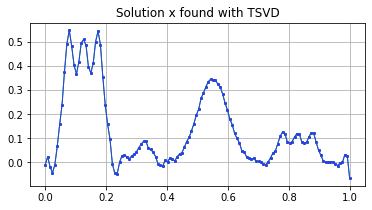

In [61]:
# Truncated Signular Value Decomposition (TSVD)
n = 128

t = np.linspace(0,1,n,endpoint=True)
x = Generate_Test_Signal(t, peaks)

noise = np.random.normal(0,0.0001,size=n)

x0 = np.zeros(n)
tol = pow(10,-7)
max_iter = 500

a = np.zeros(n)

sigma = 2
for k in range(n):
    a[k] = 1/(sigma*2.5)*np.exp(-k**2/(2*sigma**2))

Ax = sp.linalg.matmul_toeplitz(a,x)
A = sp.linalg.toeplitz(a)

plt.figure(figsize=(6,3))
plt.plot(t, x,'o-',lw=1,markersize=2)
plt.title('Signal x')
plt.grid()
plt.show()

u,s,v = sp.linalg.svd(A)
s_diag = np.diag(s)

test = np.matmul(u, np.matmul(s_diag, v))

plt.figure(figsize=(6,3))
plt.plot(s,'o-',lw=1,markersize=2)
plt.title('Singular values of A')
plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(t,Ax+noise,'o-',lw=1,markersize=2)
plt.title('Ax + noise')
plt.grid()
plt.show()

L,Li = make_L(n,a)
Li = np.linalg.pinv(L)
Li_adj = np.transpose(Li).conj()
li = Li[0]
li_adj = Li_adj[0]

x_solve_Lev = Levinson(a,Ax+noise)
x_solve_CG, i = conjugate_gradient(a,Ax+noise,x0,tol,max_iter)
x_solve_PCG, i = pre_conjugate_gradient(a,Ax+noise,x0,tol,max_iter,li,li_adj)


plt.figure(figsize=(6,3))
plt.plot(t, np.real(x_solve_Lev),'o-',lw=1,markersize=2)
plt.plot(t, np.real(x_solve_CG),'o-',lw=1,markersize=2)
plt.plot(t, np.real(x_solve_PCG),'o-',lw=1,markersize=2)
plt.title('Solution x found with original $A$')
plt.legend(['Levinson','CG','PCG'])
plt.grid()
plt.show()

cutoff = 0.15

for i in range(n):
    if s[i] < cutoff:
        s[i] = 0

s_diag = np.diag(s)

A_reconstruct = np.matmul(u,np.matmul(s_diag,v))
a_reconstruct = A_reconstruct[0]
x_solve_Lev = Levinson(a_reconstruct,Ax+noise)
x_solve_CG, i = conjugate_gradient(a_reconstruct,Ax+noise,x0,tol,max_iter)


plt.figure(figsize=(6,3))
plt.plot(t, np.real(x_solve_Lev),'o-',lw=1,markersize=2,color=dtu_green)
plt.plot(t,np.real(x_solve_CG),'o-',lw=1,markersize=2,color=dtu_blue)
plt.title('Solution x found with TSVD')
plt.grid()
plt.show()

# Example 4.2
In this example we consider a vector $a$ and compute the banded Toeplitz matrix $A$ based on $a$. We compute the eigenvalues of $A$ to see that indeed the eigenvalues of $C^{-1}A$ has eigenvalue 1.

In [64]:
n = 16

a = np.zeros(n,dtype=np.complex64)
a[0] = 10
a[1] = 5
a[2] = 2
A = sp.linalg.toeplitz(a)
eig_A = np.linalg.eigvalsh(A)
print('Eigenvalues of A:')
print(eig_A)

L,Li = make_L(n,a)
Li_adj = np.transpose(Li).conj()
pre = Li@A@Li_adj
eig_pre = np.linalg.eigvalsh(pre)
print('Eigenvalues of C^{-1}A:')
print(eig_pre)

Eigenvalues of A:
[ 3.015241   3.0228045  3.3683746  3.4377944  3.7430968  3.8987517
  4.354058   5.662786   7.515497   9.8329935 12.483254  15.282171
 18.010952  20.439774  22.35387   23.57858  ]
Eigenvalues of C^{-1}A:
[0.65404951 0.87733238 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.16247345 2.12276628]


# Example 4.5
Compute eigenvalues for $C^{-1}A$ to calculate how many that are outside $[1-\epsilon,1+\epsilon]$ for two different values of $\epsilon$.

In [65]:
# Compute eigenvalues for C^{-1}A
epsilon = 0.05

N = [8,16,32,64,128,256,512,1024,2048]
all_M = []

for n in N:

    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    for k in range(1,n):
        a[k] = (1-1j)/(1+k)**1.1

    A = sp.linalg.toeplitz(a)

    c = make_vector_c(n,a)
    C = sp.linalg.circulant(c)

    eig = np.sort(np.linalg.eigvalsh(np.linalg.inv(C)@A))

    M = 0
    for i in range(n):

        if abs(eig[i] - 1 ) > epsilon:
            M += 1
    all_M.append(M)

print('epsilon =', epsilon)
print(all_M)

epsilon = 0.01

all_M = []

for n in N:

    a = np.zeros(n,dtype=np.complex64)
    a[0] = 2
    for k in range(1,n):
        a[k] = (1-1j)/(1+k)**1.1

    A = sp.linalg.toeplitz(a)

    c = make_vector_c(n,a)
    C = sp.linalg.circulant(c)

    eig = np.sort(np.linalg.eigvalsh(np.linalg.inv(C)@A))

    M = 0
    for i in range(n):

        if abs(eig[i] - 1 ) > epsilon:
            M += 1
    all_M.append(M)

print('epsilon =', epsilon)
print(all_M)


epsilon = 0.05
[8, 15, 13, 12, 7, 5, 6, 6, 6]
epsilon = 0.01
[8, 16, 31, 63, 58, 55, 39, 20, 16]
